In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.nn.utils.parametrize as parametrize
from tqdm import tqdm

## Hyperparameters

In [3]:
BATCH_SIZE = 200

TEST_SIZE = 0.2

N_EPOCH = 20
LEARNING_RATES = 0.001

torch.manual_seed(689)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## Dataset preparations

In [4]:
from automata import DFA, TorchData, AutomataRNN, ParametrizeRNN
from datas import principal

In [12]:
even, sink, fix, unique = principal(even=True, sink=True, fix=True, unique=True)

Generate dataset 'even'...
Done! in 4.6125 sec
Generate dataset 'sink'...
Done! in 47.3199 sec
Generate 'fix'...
Done! in 4.8483 sec
Generate 'unique'...
Done! in 4.4250 sec


In [6]:
def makeloader(automaton:DFA):
    train, test = random_split(TorchData(automaton), [1-TEST_SIZE, TEST_SIZE])

    train = DataLoader(train, BATCH_SIZE, shuffle=True)
    test = next(iter(DataLoader(test, len(test))))

    return train, test
    

evenloader, testeven = makeloader(even)
fixloader, testfix = makeloader(fix)
uniqueloader, testunique = makeloader(unique)

## RNN training

In [7]:
def parametrizevsnot(automaton:DFA, loss = nn.BCELoss(), optimizer = torch.optim.Adam, returnautomat=False):
    trainloader, test = makeloader(automaton)

    noparam = AutomataRNN(automaton, device=device).to(device)
    optim = optimizer(noparam.parameters(), lr=LEARNING_RATES)
    optim.zero_grad()

    losslistnoinit = list()

    for epoch in range(N_EPOCH):
        trainer = iter(trainloader)
        for _ in tqdm(range(len(trainloader)), desc=f"Epoch {epoch+1}...", ncols=75):
            words, lengths, labels = next(trainer)
            labels = labels.to(dtype = torch.float32)

            out = noparam(words, lengths)

            losslistnoinit.append(loss(out, labels))
            losslistnoinit[-1].backward()

            optim.step()
            optim.zero_grad()

        with torch.no_grad():
            predictions = noparam.predict(test[0], test[1])
            acc = torch.sum(predictions == test[2].reshape(-1), dim=0) * 100 / len(test[2])
            print(f"Done! Trainloss: {losslistnoinit[-1]:.6f}, Test accuracy: {acc:.4f}")

    print("\nNon parametrized RNN done!\n")

    withparam = ParametrizeRNN(automaton, device=device).to(device)

    optim = optimizer(withparam.parameters(), lr=LEARNING_RATES)
    optim.zero_grad()

    losslistinit = list()

    for epoch in range(N_EPOCH):
        trainer = iter(trainloader)
        for _ in tqdm(range(len(trainloader)), desc=f"Epoch {epoch+1}...", ncols=75):
            words, lengths, labels = next(trainer)
            labels = labels.to(dtype = torch.float32)

            out = withparam(words, lengths)

            losslistinit.append(loss(out, labels))
            losslistinit[-1].backward()

            optim.step()
            optim.zero_grad()

        with torch.no_grad():
            predictions = withparam.predict(test[0], test[1])
            acc = torch.sum(predictions == test[2].reshape(-1), dim=0) * 100 / len(test[2])
            print(f"Done! Trainloss: {losslistinit[-1]:.6f}, Test accuracy: {acc:.4f}")

    print("\nParametrized RNN done!")
    if returnautomat:
        return (losslistnoinit, noparam), (losslistinit, withparam)
    else:
        return losslistnoinit, losslistinit
            

### Even

In [7]:
evennop, evenp = parametrizevsnot(even)

Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 37.55it/s]


Done! Trainloss: 0.700114, Test accuracy: 51.9500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:00<00:00, 41.20it/s]


Done! Trainloss: 0.700668, Test accuracy: 51.9000

Non parametrized RNN done!



Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 37.98it/s]


Done! Trainloss: 0.694074, Test accuracy: 52.0000


Epoch 2...: 100%|██████████████████████████| 40/40 [00:00<00:00, 45.94it/s]

Done! Trainloss: 0.694512, Test accuracy: 52.0000

Parametrized RNN done!


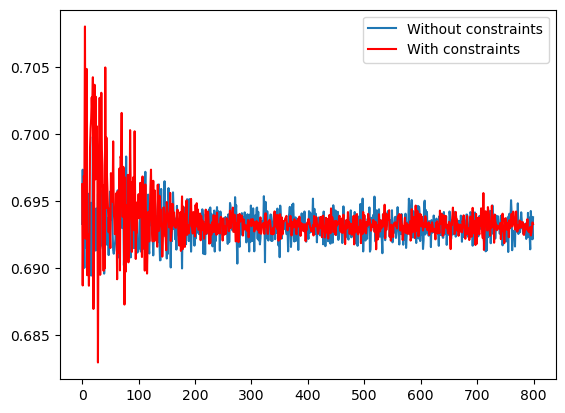

In [25]:
with torch.no_grad():
    plt.plot(evennop, label = "Without constraints")
    plt.plot(evenp, "r", label="With constraints")
    plt.legend()
    plt.show()
    

### Sink

In [14]:
(sinknop, sinkRNN), (sinkp, sinkPRNN) = parametrizevsnot(sink, returnautomat=True)

Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.01it/s]


Done! Trainloss: 0.605961, Test accuracy: 67.2500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 24.54it/s]


Done! Trainloss: 0.540461, Test accuracy: 70.8000


Epoch 3...: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.11it/s]


Done! Trainloss: 0.401053, Test accuracy: 93.2000


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.24it/s]


Done! Trainloss: 0.299236, Test accuracy: 95.5000


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 23.06it/s]


Done! Trainloss: 0.254593, Test accuracy: 98.8500


Epoch 6...: 100%|██████████████████████████| 40/40 [00:01<00:00, 25.41it/s]


Done! Trainloss: 0.190790, Test accuracy: 98.8500


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 24.81it/s]


Done! Trainloss: 0.165726, Test accuracy: 98.9000


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.26it/s]


Done! Trainloss: 0.154504, Test accuracy: 98.9000


Epoch 9...: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.76it/s]


Done! Trainloss: 0.109847, Test accuracy: 98.9000


Epoch 10...: 100%|█████████████████████████| 40/40 [00:01<00:00, 26.28it/s]


Done! Trainloss: 0.096448, Test accuracy: 100.0000


Epoch 11...: 100%|█████████████████████████| 40/40 [00:01<00:00, 23.50it/s]


Done! Trainloss: 0.075810, Test accuracy: 99.9000


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 25.33it/s]


Done! Trainloss: 0.059200, Test accuracy: 100.0000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 21.80it/s]


Done! Trainloss: 0.068237, Test accuracy: 100.0000


Epoch 14...: 100%|█████████████████████████| 40/40 [00:01<00:00, 20.32it/s]


Done! Trainloss: 0.046556, Test accuracy: 100.0000


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 25.32it/s]


Done! Trainloss: 0.044031, Test accuracy: 100.0000


Epoch 16...: 100%|█████████████████████████| 40/40 [00:01<00:00, 24.57it/s]


Done! Trainloss: 0.038710, Test accuracy: 100.0000


Epoch 17...: 100%|█████████████████████████| 40/40 [00:01<00:00, 23.53it/s]


Done! Trainloss: 0.037593, Test accuracy: 100.0000


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 21.37it/s]


Done! Trainloss: 0.029421, Test accuracy: 100.0000


Epoch 19...: 100%|█████████████████████████| 40/40 [00:02<00:00, 15.54it/s]


Done! Trainloss: 0.029811, Test accuracy: 100.0000


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 20.86it/s]


Done! Trainloss: 0.026017, Test accuracy: 100.0000

Non parametrized RNN done!



Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.02it/s]


Done! Trainloss: 0.661032, Test accuracy: 79.0500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 21.45it/s]


Done! Trainloss: 0.631645, Test accuracy: 79.0500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:01<00:00, 22.77it/s]


Done! Trainloss: 0.594883, Test accuracy: 89.8500


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 25.93it/s]


Done! Trainloss: 0.542437, Test accuracy: 89.8500


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 23.22it/s]


Done! Trainloss: 0.511822, Test accuracy: 89.8500


Epoch 6...: 100%|██████████████████████████| 40/40 [00:02<00:00, 19.50it/s]


Done! Trainloss: 0.468303, Test accuracy: 89.8500


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.29it/s]


Done! Trainloss: 0.418645, Test accuracy: 89.8500


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.40it/s]


Done! Trainloss: 0.365337, Test accuracy: 89.8500


Epoch 9...: 100%|██████████████████████████| 40/40 [00:01<00:00, 24.28it/s]


Done! Trainloss: 0.256445, Test accuracy: 97.6500


Epoch 10...: 100%|█████████████████████████| 40/40 [00:01<00:00, 21.94it/s]


Done! Trainloss: 0.168659, Test accuracy: 98.3000


Epoch 11...: 100%|█████████████████████████| 40/40 [00:01<00:00, 24.69it/s]


Done! Trainloss: 0.139244, Test accuracy: 98.7500


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 24.79it/s]


Done! Trainloss: 0.131435, Test accuracy: 98.9000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 23.78it/s]


Done! Trainloss: 0.113565, Test accuracy: 98.8500


Epoch 14...: 100%|█████████████████████████| 40/40 [00:01<00:00, 20.03it/s]


Done! Trainloss: 0.090408, Test accuracy: 98.9000


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 24.89it/s]


Done! Trainloss: 0.080415, Test accuracy: 98.9000


Epoch 16...: 100%|█████████████████████████| 40/40 [00:01<00:00, 24.22it/s]


Done! Trainloss: 0.068897, Test accuracy: 99.1500


Epoch 17...: 100%|█████████████████████████| 40/40 [00:01<00:00, 22.99it/s]


Done! Trainloss: 0.063838, Test accuracy: 99.9500


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 24.24it/s]


Done! Trainloss: 0.056426, Test accuracy: 100.0000


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 21.84it/s]


Done! Trainloss: 0.049937, Test accuracy: 99.9000


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 22.34it/s]


Done! Trainloss: 0.045006, Test accuracy: 100.0000

Parametrized RNN done!


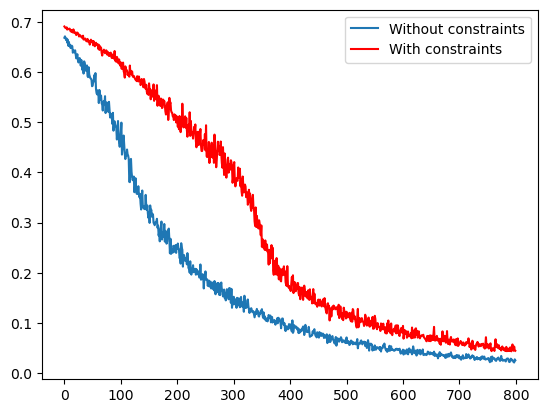

In [15]:
with torch.no_grad():
    plt.plot(sinknop, label = "Without constraints")
    plt.plot(sinkp, "r", label="With constraints")
    plt.legend()
    plt.show()
    

In [21]:
sink.probas = "equal"

sink.dataset(10000, meanlen = 12, max_try = 10000, random_state=690)

sinkmoretest = next(iter(DataLoader(TorchData(sink), 10000)))

with torch.no_grad():
    predictions = sinkRNN.predict(sinkmoretest[0], sinkmoretest[1])
    acc = torch.sum(predictions == sinkmoretest[2].reshape(-1), dim=0) * 100 / len(sinkmoretest[2])
    print(f"Test accuracy: {acc:.4f}")

/home/mt-ubu2/Documents/Internship/RNN_autmata/automata.py:325: UserWarning: `max_try` limit reach. Final prop = 0.0002
  warn(f"`max_try` limit reach. Final prop = {sum(labels)/len(labels)}")


Test accuracy: 98.3000


## Fix

In [16]:
fixnop, fixp = parametrizevsnot(fix)

Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 20.61it/s]


Done! Trainloss: 0.390294, Test accuracy: 79.9500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 25.19it/s]


Done! Trainloss: 0.223307, Test accuracy: 93.8500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:02<00:00, 16.50it/s]


Done! Trainloss: 0.110375, Test accuracy: 100.0000


Epoch 4...: 100%|██████████████████████████| 40/40 [00:02<00:00, 14.73it/s]


Done! Trainloss: 0.040933, Test accuracy: 100.0000


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 28.79it/s]


Done! Trainloss: 0.026930, Test accuracy: 100.0000


Epoch 6...: 100%|██████████████████████████| 40/40 [00:01<00:00, 27.39it/s]


Done! Trainloss: 0.018430, Test accuracy: 100.0000


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 27.30it/s]


Done! Trainloss: 0.012739, Test accuracy: 100.0000


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.14it/s]


Done! Trainloss: 0.009972, Test accuracy: 100.0000


Epoch 9...: 100%|██████████████████████████| 40/40 [00:06<00:00,  6.46it/s]


Done! Trainloss: 0.008148, Test accuracy: 100.0000


Epoch 10...: 100%|█████████████████████████| 40/40 [00:01<00:00, 24.97it/s]


Done! Trainloss: 0.006543, Test accuracy: 100.0000


Epoch 11...: 100%|█████████████████████████| 40/40 [00:01<00:00, 27.54it/s]


Done! Trainloss: 0.005345, Test accuracy: 100.0000


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 28.07it/s]


Done! Trainloss: 0.004509, Test accuracy: 100.0000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 25.60it/s]


Done! Trainloss: 0.004145, Test accuracy: 100.0000


Epoch 14...: 100%|█████████████████████████| 40/40 [00:01<00:00, 30.95it/s]


Done! Trainloss: 0.003462, Test accuracy: 100.0000


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.78it/s]


Done! Trainloss: 0.003084, Test accuracy: 100.0000


Epoch 16...: 100%|█████████████████████████| 40/40 [00:01<00:00, 28.28it/s]


Done! Trainloss: 0.002732, Test accuracy: 100.0000


Epoch 17...: 100%|█████████████████████████| 40/40 [00:01<00:00, 27.58it/s]


Done! Trainloss: 0.002565, Test accuracy: 100.0000


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 28.56it/s]


Done! Trainloss: 0.002299, Test accuracy: 100.0000


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 27.35it/s]


Done! Trainloss: 0.001928, Test accuracy: 100.0000


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 26.04it/s]


Done! Trainloss: 0.001879, Test accuracy: 100.0000

Non parametrized RNN done!



Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 27.33it/s]


Done! Trainloss: 0.527233, Test accuracy: 85.5000


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.25it/s]


Done! Trainloss: 0.333119, Test accuracy: 94.9500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:01<00:00, 25.59it/s]


Done! Trainloss: 0.228649, Test accuracy: 92.9000


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.59it/s]


Done! Trainloss: 0.154172, Test accuracy: 99.0500


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 29.07it/s]


Done! Trainloss: 0.089864, Test accuracy: 99.0500


Epoch 6...: 100%|██████████████████████████| 40/40 [00:01<00:00, 25.10it/s]


Done! Trainloss: 0.056542, Test accuracy: 99.5500


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 27.42it/s]


Done! Trainloss: 0.034865, Test accuracy: 100.0000


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 30.27it/s]


Done! Trainloss: 0.018266, Test accuracy: 100.0000


Epoch 9...: 100%|██████████████████████████| 40/40 [00:01<00:00, 22.87it/s]


Done! Trainloss: 0.014679, Test accuracy: 100.0000


Epoch 10...: 100%|█████████████████████████| 40/40 [00:01<00:00, 27.34it/s]


Done! Trainloss: 0.010123, Test accuracy: 100.0000


Epoch 11...: 100%|█████████████████████████| 40/40 [00:01<00:00, 26.13it/s]


Done! Trainloss: 0.008847, Test accuracy: 100.0000


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 24.12it/s]


Done! Trainloss: 0.006937, Test accuracy: 100.0000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 28.19it/s]


Done! Trainloss: 0.005815, Test accuracy: 100.0000


Epoch 14...: 100%|█████████████████████████| 40/40 [00:01<00:00, 29.62it/s]


Done! Trainloss: 0.005089, Test accuracy: 100.0000


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 27.13it/s]


Done! Trainloss: 0.004398, Test accuracy: 100.0000


Epoch 16...: 100%|█████████████████████████| 40/40 [00:01<00:00, 25.22it/s]


Done! Trainloss: 0.003654, Test accuracy: 100.0000


Epoch 17...: 100%|█████████████████████████| 40/40 [00:01<00:00, 28.88it/s]


Done! Trainloss: 0.003706, Test accuracy: 100.0000


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 27.20it/s]


Done! Trainloss: 0.003313, Test accuracy: 100.0000


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 23.74it/s]


Done! Trainloss: 0.002855, Test accuracy: 100.0000


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 29.85it/s]


Done! Trainloss: 0.002870, Test accuracy: 100.0000

Parametrized RNN done!


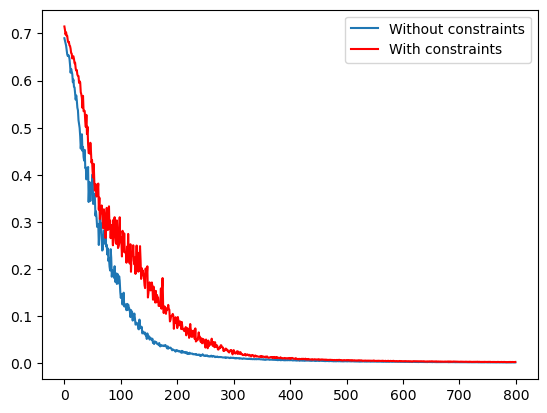

In [17]:
with torch.no_grad():
    plt.plot(fixnop, label = "Without constraints")
    plt.plot(fixp, "r", label="With constraints")
    plt.legend()
    plt.show()
    

## Unique

In [18]:
(uniquenop, uniquenop_model), (uniquep, uniquep_model) = parametrizevsnot(unique, returnautomat=True)

Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 22.32it/s]


Done! Trainloss: 0.691192, Test accuracy: 50.5500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 21.82it/s]


Done! Trainloss: 0.692681, Test accuracy: 50.4000


Epoch 3...: 100%|██████████████████████████| 40/40 [00:01<00:00, 23.40it/s]


Done! Trainloss: 0.690042, Test accuracy: 47.7500


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 21.60it/s]


Done! Trainloss: 0.692122, Test accuracy: 47.7500


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 24.07it/s]


Done! Trainloss: 0.670203, Test accuracy: 64.9500


Epoch 6...: 100%|██████████████████████████| 40/40 [00:01<00:00, 23.18it/s]


Done! Trainloss: 0.514907, Test accuracy: 79.4000


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 21.05it/s]


Done! Trainloss: 0.410702, Test accuracy: 79.8500


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 23.51it/s]


Done! Trainloss: 0.271024, Test accuracy: 79.5000


Epoch 9...: 100%|██████████████████████████| 40/40 [00:01<00:00, 23.34it/s]


Done! Trainloss: 0.324358, Test accuracy: 90.9500


Epoch 10...: 100%|█████████████████████████| 40/40 [00:01<00:00, 20.33it/s]


Done! Trainloss: 0.264550, Test accuracy: 91.9500


Epoch 11...: 100%|█████████████████████████| 40/40 [00:01<00:00, 24.80it/s]


Done! Trainloss: 0.245730, Test accuracy: 91.4500


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 22.11it/s]


Done! Trainloss: 0.257515, Test accuracy: 91.9000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 21.46it/s]


Done! Trainloss: 0.204802, Test accuracy: 93.0000


Epoch 14...: 100%|█████████████████████████| 40/40 [00:01<00:00, 23.82it/s]


Done! Trainloss: 0.265895, Test accuracy: 90.6500


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 23.71it/s]


Done! Trainloss: 0.180174, Test accuracy: 92.0500


Epoch 16...: 100%|█████████████████████████| 40/40 [00:01<00:00, 23.31it/s]


Done! Trainloss: 0.200183, Test accuracy: 92.9500


Epoch 17...: 100%|█████████████████████████| 40/40 [00:01<00:00, 25.67it/s]


Done! Trainloss: 0.250156, Test accuracy: 92.7000


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 24.76it/s]


Done! Trainloss: 0.166451, Test accuracy: 94.0500


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 21.43it/s]


Done! Trainloss: 0.174298, Test accuracy: 94.6500


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 20.15it/s]


Done! Trainloss: 0.136257, Test accuracy: 94.2000

Non parametrized RNN done!



Epoch 1...: 100%|██████████████████████████| 40/40 [00:02<00:00, 17.42it/s]


Done! Trainloss: 0.692135, Test accuracy: 49.8000


Epoch 2...: 100%|██████████████████████████| 40/40 [00:02<00:00, 17.77it/s]


Done! Trainloss: 0.694890, Test accuracy: 49.9500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:02<00:00, 17.07it/s]


Done! Trainloss: 0.690286, Test accuracy: 50.1000


Epoch 4...: 100%|██████████████████████████| 40/40 [00:02<00:00, 19.16it/s]


Done! Trainloss: 0.697176, Test accuracy: 49.6500


Epoch 5...: 100%|██████████████████████████| 40/40 [00:02<00:00, 17.14it/s]


Done! Trainloss: 0.694025, Test accuracy: 49.8500


Epoch 6...: 100%|██████████████████████████| 40/40 [00:02<00:00, 19.55it/s]


Done! Trainloss: 0.694813, Test accuracy: 48.6000


Epoch 7...: 100%|██████████████████████████| 40/40 [00:02<00:00, 19.58it/s]


Done! Trainloss: 0.692117, Test accuracy: 49.7500


Epoch 8...: 100%|██████████████████████████| 40/40 [00:02<00:00, 18.51it/s]


Done! Trainloss: 0.690340, Test accuracy: 48.5000


Epoch 9...: 100%|██████████████████████████| 40/40 [00:05<00:00,  7.35it/s]


Done! Trainloss: 0.692409, Test accuracy: 48.8000


Epoch 10...: 100%|█████████████████████████| 40/40 [00:02<00:00, 19.99it/s]


Done! Trainloss: 0.691480, Test accuracy: 49.1000


Epoch 11...: 100%|█████████████████████████| 40/40 [00:02<00:00, 17.89it/s]


Done! Trainloss: 0.694971, Test accuracy: 48.7000


Epoch 12...: 100%|█████████████████████████| 40/40 [00:02<00:00, 19.78it/s]


Done! Trainloss: 0.691274, Test accuracy: 48.6000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:10<00:00,  3.96it/s]


Done! Trainloss: 0.697495, Test accuracy: 49.6000


Epoch 14...: 100%|█████████████████████████| 40/40 [00:06<00:00,  5.82it/s]


Done! Trainloss: 0.688979, Test accuracy: 49.5500


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 20.01it/s]


Done! Trainloss: 0.688663, Test accuracy: 48.3000


Epoch 16...: 100%|█████████████████████████| 40/40 [00:02<00:00, 19.68it/s]


Done! Trainloss: 0.689457, Test accuracy: 47.4000


Epoch 17...: 100%|█████████████████████████| 40/40 [00:02<00:00, 18.44it/s]


Done! Trainloss: 0.690766, Test accuracy: 48.1500


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 24.37it/s]


Done! Trainloss: 0.698895, Test accuracy: 48.4500


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 23.17it/s]


Done! Trainloss: 0.693646, Test accuracy: 47.3000


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 24.50it/s]


Done! Trainloss: 0.694092, Test accuracy: 48.6000

Parametrized RNN done!


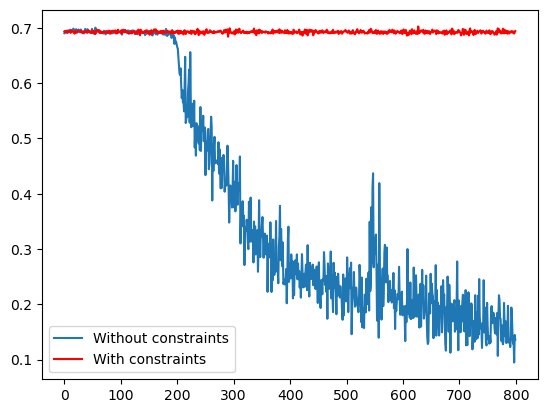

: 

In [19]:
with torch.no_grad():
    plt.plot(uniquenop, label = "Without constraints")
    plt.plot(uniquep, "r", label="With constraints")
    plt.legend()
    plt.show()
    

In [9]:
uniquep_model.state_dict()

OrderedDict([('rnn.parametrizations.weight_hh_l0.original',
              tensor([[-0.1373,  0.0000,  0.0000,  0.0000, -0.0719,  0.0000,  0.0000,  0.0000,
                        0.0983,  0.0000,  0.0000,  0.0000, -0.0124,  0.0000,  0.0000,  0.0000,
                        0.0874,  0.0000,  0.0000,  0.0000,  0.1076,  0.0000,  0.0000,  0.0000],
                      [-0.1041,  0.0000,  0.0000,  0.0000, -0.1358,  0.0000,  0.0000,  0.0000,
                       -0.1165,  0.0000,  0.0000,  0.0000,  0.1225,  0.0000,  0.0000,  0.0000,
                        0.0817,  0.0000,  0.0000,  0.0000, -0.2000,  0.0000,  0.0000,  0.0000],
                      [-0.0402,  0.0000,  0.0000,  0.0000, -0.0784,  0.0000,  0.0000,  0.0000,
                       -0.0390,  0.0000,  0.0000,  0.0000, -0.1444,  0.0000,  0.0000,  0.0000,
                       -0.1381,  0.0000,  0.0000,  0.0000, -0.0394,  0.0000,  0.0000,  0.0000],
                      [-0.0163,  0.0000,  0.0000,  0.0000,  0.0519,  0.0000,  0.00

In [21]:
uniquep_model.rnn.all_weights#parametrizations["weight_hh_l0"][0].change_base

[[tensor([[0.0657, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0657, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0657, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0657],
          [0.0657, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0657, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0657, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0657],
          [0.0657, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0657, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0657, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0657],
          [0.0657, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0657, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0657, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0657],
          [0.0657, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0657, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0657, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0657],
          [0.0657, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0657, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.065